# This notebook was based on [this](https://www.kaggle.com/code/tientd95/pyspark-for-data-science) notebook. I used it as a resource to deepen my knowledge in Pyspark

In [5]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import mean, col, split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.classification import GBTClassifier

# Configuring Kaggle API

In [11]:
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%%bash
# Copying kaggle api key to working directory
cp drive/MyDrive/Colab\ Notebooks/kaggle.json .
# Then move kaggle.json into the folder where the API expects to find it.
mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# downloading datasets
kaggle datasets download -d tientd95/movierating
kaggle competitions download -c titanic

100%|██████████| 383k/383k [00:00<00:00, 133MB/s]
100%|██████████| 34.1k/34.1k [00:00<00:00, 35.5MB/s]


# **1. Movie Recommendation with Pyspark** <a class="anchor" id="1"></a>

In [ ]:
# Create SparkSession
spark = SparkSession.builder.appName('recommender_system').getOrCreate()

In [13]:
df = spark.read.csv('movie_ratings_df.csv', inferSchema=True, header=True)
df.limit(3).toPandas()

,userId,title,rating
0,196,Kolya (1996),3
1,63,Kolya (1996),3
2,226,Kolya (1996),5


## Our task: given a user, we predict and return a list of movies recommendation for that user to watch.

### We use: **printSchema()** to quick overview of features datatype

In [14]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



In [15]:

stringIndexer = StringIndexer(inputCol='title', outputCol='title_new')
model = stringIndexer.fit(df)
indexed = model.transform(df)
indexed.limit(5).show() 

+------+------------+------+---------+
|userId|       title|rating|title_new|
+------+------------+------+---------+
|   196|Kolya (1996)|     3|    287.0|
|    63|Kolya (1996)|     3|    287.0|
|   226|Kolya (1996)|     5|    287.0|
|   154|Kolya (1996)|     3|    287.0|
|   306|Kolya (1996)|     5|    287.0|
+------+------------+------+---------+



In [17]:
# Using Alternating least Square algorithm to perform the recommendations
train, test = indexed.randomSplit([0.75,0.25])
#Training the recommender model using train datatset
rec=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='userId'
        ,itemCol='title_new'
        ,ratingCol='rating'
        ,nonnegative=True
        ,coldStartStrategy="drop")

#fit the model on train set
rec_model=rec.fit(train)

#making predictions on test set 
predicted_ratings=rec_model.transform(test)
predicted_ratings.limit(5).toPandas()

,userId,title,rating,title_new,prediction
0,148,Back to the Future (1985),3,20.0,3.321964
1,148,Being There (1979),5,290.0,5.438693
2,148,Blade Runner (1982),5,52.0,4.428960
3,148,Cold Comfort Farm (1995),5,262.0,4.178506
4,148,Forrest Gump (1994),5,27.0,3.893533


In [20]:
evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol='rating')
rmse = evaluator.evaluate(predicted_ratings)
print(rmse)

1.0223555170448135


In [21]:
# First we need to create dataset of all distinct movies 
unique_movies=indexed.select('title_new').distinct()

#create function to recommend top 'n' movies to any particular user
def top_movies(user_id,n):
    """
    This function returns the top 'n' movies that user has not seen yet but might like 
    
    """
    #assigning alias name 'a' to unique movies df
    a = unique_movies.alias('a')
    
    #creating another dataframe which contains already watched movie by active user 
    watched_movies=indexed.filter(indexed['userId'] == user_id).select('title_new')
    
    #assigning alias name 'b' to watched movies df
    b=watched_movies.alias('b')
    
    #joining both tables on left join 
    total_movies = a.join(b, a.title_new == b.title_new,how='left')
    
    #selecting movies which active user is yet to rate or watch
    remaining_movies=total_movies.where(col("b.title_new").isNull()).select(a.title_new).distinct()
    
    
    #adding new column of user_Id of active useer to remaining movies df 
    remaining_movies=remaining_movies.withColumn("userId",lit(int(user_id)))
    
    
    #making recommendations using ALS recommender model and selecting only top 'n' movies
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)
    
    
    #adding columns of movie titles in recommendations
    movie_title = IndexToString(inputCol="title_new", outputCol="title",labels=model.labels)
    final_recommendations=movie_title.transform(recommendations)
    
    #return the recommendations to active user
    return final_recommendations.show(n,False)

In [22]:
top_movies(60,5)

+---------+------+----------+------------------------------------------+
|title_new|userId|prediction|title                                     |
+---------+------+----------+------------------------------------------+
|1277.0   |60    |7.202069  |Mina Tannenbaum (1994)                    |
|696.0    |60    |6.428572  |Basketball Diaries, The (1995)            |
|865.0    |60    |6.1992526 |Burnt By the Sun (1994)                   |
|1347.0   |60    |6.1013064 |Angel Baby (1995)                         |
|841.0    |60    |5.930515  |Ghost in the Shell (Kokaku kidotai) (1995)|
+---------+------+----------+------------------------------------------+



# 2. Classification model in pyspark

In [23]:
# Firstly we create sparkSession (like a container)
spark = SparkSession.builder.appName('Play with pyspark ML on titatic_dataset').getOrCreate()
# After creating spark, we use spark.read.csv to read dataset, like pandas.read_csv
df = spark.read.csv('train.csv',header = 'True',inferSchema='True')

In [24]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [25]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



## Checking null values in Pyspark

* isnan() is a function of the pysparq.sql.function package, we have to set which column we want to use as an argument of the function. 
* isNull()" belongs to pyspark.sql.Column package, to check the null status of a column

To check null in Pyspark, we use both function above

In [27]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [28]:
df = df.drop("Cabin")

In [29]:
df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [30]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Checking the average age by Initials
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [31]:
# Assigning missing values in age feature based on average age of Initials
df = df.withColumn("Age",when((df["Initial"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))

In [32]:
# Embarked columns has two missing values, let check it
df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [33]:
# As we can see, Majority Passengers boarded from "S". We can assign missing value with "S"
df = df.na.fill({"Embarked" : 'S'})
# Check again the missing value status
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



In [34]:
df = df.withColumn("Family_Size",col('SibSp')+col('Parch')) # Create new column: Family_size
df = df.withColumn('Alone',lit(0))  # Create new column: Alone and assign 0 default value to Alone column
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))

# converting Sex, Embarked & Initial columns from string to number using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [35]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0


In [36]:
# Now we drop columns that not needed for modelling
df = df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

# Before modelling in Pyspark, we need to put all features to Vector using Pyspark VectorAssembler
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


In [37]:
# for data split in pyspark, we can use df.randomSplit()
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

In [38]:
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



## Gradient Boosted Tree

If you want to run the below part, just uncomment it. I dit it in order to reduce the time of committing the kernel.

In [42]:
gbt = GBTClassifier(labelCol="Survived")
paramGrid = ParamGridBuilder()\
                            .addGrid(gbt.maxDepth, [5, 10, 20]) \
                            .addGrid(gbt.maxBins, [20, 32, 50]) \
                            .addGrid(gbt.maxIter, [10, 20, 30]) \
                            .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
                            .build()
    
tvs = TrainValidationSplit(estimator=gbt
                           , estimatorParamMaps=paramGrid
                            ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                            ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))


Accuracy:  0.7978723404255319
Precision:  0.8005219164933611


### Evaluating ROC metric

In [43]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.8736829501915709


### Visualizing AUC metrics

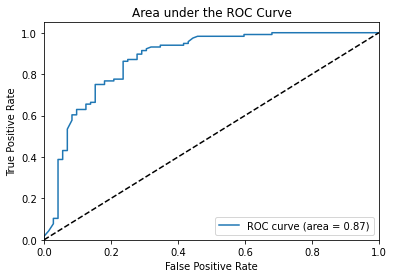

In [44]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()